In [126]:
# IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.reselience_metrics import (
    EvalWindows,
    to_performance,
    compute_all,
)


In [150]:
# === PATH TO YOUR RUN FILES (.npz) ===
PATH_PERT = "test_hangzhou/Ours_Normal_Block/1_step_metrics.npz"     # run WITH perturbation
PATH_BASE = "test_hangzhou/Ours_Normal_Normal/1_step_metrics.npz"              # control run WITHOUT perturbation

# time axis (must exist in BOTH files)
TIME_KEY = "t"

# Metric keys (one pair per performance metric you want to evaluate)
KEYMAP = {
    "speed":  ("speed", "speed"),        # (pert_key, base_key)
    "queue":  ("queue", "queue"),
    "wait":   ("wait", "wait"),
    "reward": ("ret", "ret"),
}

# Which metrics to evaluate in this run
SELECTED = ["speed", "queue", "wait"]  # or ["speed"] or add "reward" if meaningful

# === Windows (seconds or steps; must match your time units) ===
wins = EvalWindows(
    pre_start=0,  # start of pre-shock window
    t0=1200,         # shock start
    t1=2400,         # shock end
    post_end=3600    # end of evaluation horizon
)

# Normalization rule baked in our util:
# - higher_is_better=True  -> minmax
# - higher_is_better=False -> inv1p
DIRECTION = {
    "speed":  True,   # higher is better
    "reward": True,   # often higher is better (if your reward is aligned that way)
    "queue":  False,  # lower is better
    "wait":   False,  # lower is better
}

EPISODE = 1
SEED = 45
SEEDS = [42,43,44,45,46]

In [151]:
def array_to_series(t: np.ndarray, x: np.ndarray) -> pd.Series:
    """Create a pandas Series indexed by time/step."""
    return pd.Series(x, index=t).sort_index()

In [152]:
# Load files
pert = np.load(PATH_PERT,allow_pickle=True)
base = np.load(PATH_BASE,allow_pickle=True)
# Load the step log dict
pert = pert["step_log"].item()
base = base["step_log"].item()



In [153]:
all_rows = []
all_series_pert = {}
all_series_base= {}
for seed in SEEDS:
    # Extract time axes for this seed
    t_pert = pert[seed][EPISODE][TIME_KEY]
    t_base = base[seed][EPISODE][TIME_KEY]
    # Build series per metric for this seed
    series_pert = {}
    series_base = {}
    for name in SELECTED:
        k_pert, k_base = KEYMAP[name]
        x_pert = pert[seed][EPISODE][k_pert]
        x_base = base[seed][EPISODE][k_base]
        series_pert[name] = array_to_series(t_pert, x_pert)
        series_base[name] = array_to_series(t_base, x_base)
    # Compute resilience metrics per selected metric
    for name in SELECTED:
        higher_is_better = DIRECTION[name]
        # 1) Normalize perturbed run into performance P(t)
        P = to_performance(
            series_pert[name],
            higher_is_better=higher_is_better,
            ref_window=wins.pre,
            allow_clip=False
        )
        # 2) Compute resilience metrics using baseline raw series
        res = compute_all(
            P, wins,
            baseline_raw=series_base[name],
            higher_is_better=higher_is_better,
            target=0.9,    # RT90
            band=0.05
        )
        res["metric"] = name
        res["seed"] = seed
        all_rows.append(res)
        all_series_pert[seed]=series_pert
        all_series_base[seed]=series_base
# Per-seed results (one row per seed × metric)
results_df = pd.DataFrame(all_rows).set_index(["metric","seed"]).sort_index()
display(results_df)

auc_ratio  peak_loss  rt_target  residual_delta
metric seed                                                 
queue  42     1.059994   0.169701        0.0        0.048437
       43     1.009618   0.264084        0.0        0.034279
       44     1.063172   0.181554        0.0        0.049336
       45     0.986013   0.284556        0.0        0.033621
       46     1.010447   0.226345        0.0        0.033827
speed  42     1.035178   0.347392        0.0        0.167614
       43     1.020616   0.380350        0.0        0.192519
       44     0.987074   0.373506        0.0        0.192655
       45     0.983926   0.484090        0.0        0.187007
       46     0.951486   0.429939        0.0        0.144082
wait   42     1.051932   0.290163        0.0        0.046777
       43     1.004715   0.409933        0.0        0.021274
       44     1.074134   0.240863        0.0        0.052778
       45     0.970031   0.371510        0.0        0.027321
       46     0.979814   0.342840        0.0        0.012556

In [154]:
# Show mean ± std across seeds for each metric (speed / queue / wait)
summary = (results_df
           .groupby("metric")
           .agg(["mean","std"])
           .round(3))
display(summary)

auc_ratio        peak_loss        rt_target      residual_delta       
            mean    std      mean    std      mean  std           mean    std
metric                                                                       
queue      1.026  0.034     0.225  0.050       0.0  0.0          0.040  0.008
speed      0.996  0.033     0.403  0.054       0.0  0.0          0.177  0.021
wait       1.016  0.045     0.331  0.067       0.0  0.0          0.032  0.017

In [155]:
def plot_raw_overlay_simple(raw_pert, raw_base, wins, ylabel="", title=""):
    plt.figure(figsize=(15,8))
    plt.plot(raw_pert.index, raw_pert.values, label="Perturbed")
    plt.plot(raw_base.index, raw_base.values, label="Baseline")
    # shade perturbation window
    plt.axvspan(wins.t0, wins.t1, color="gray", alpha=0.3, label="Perturbation")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

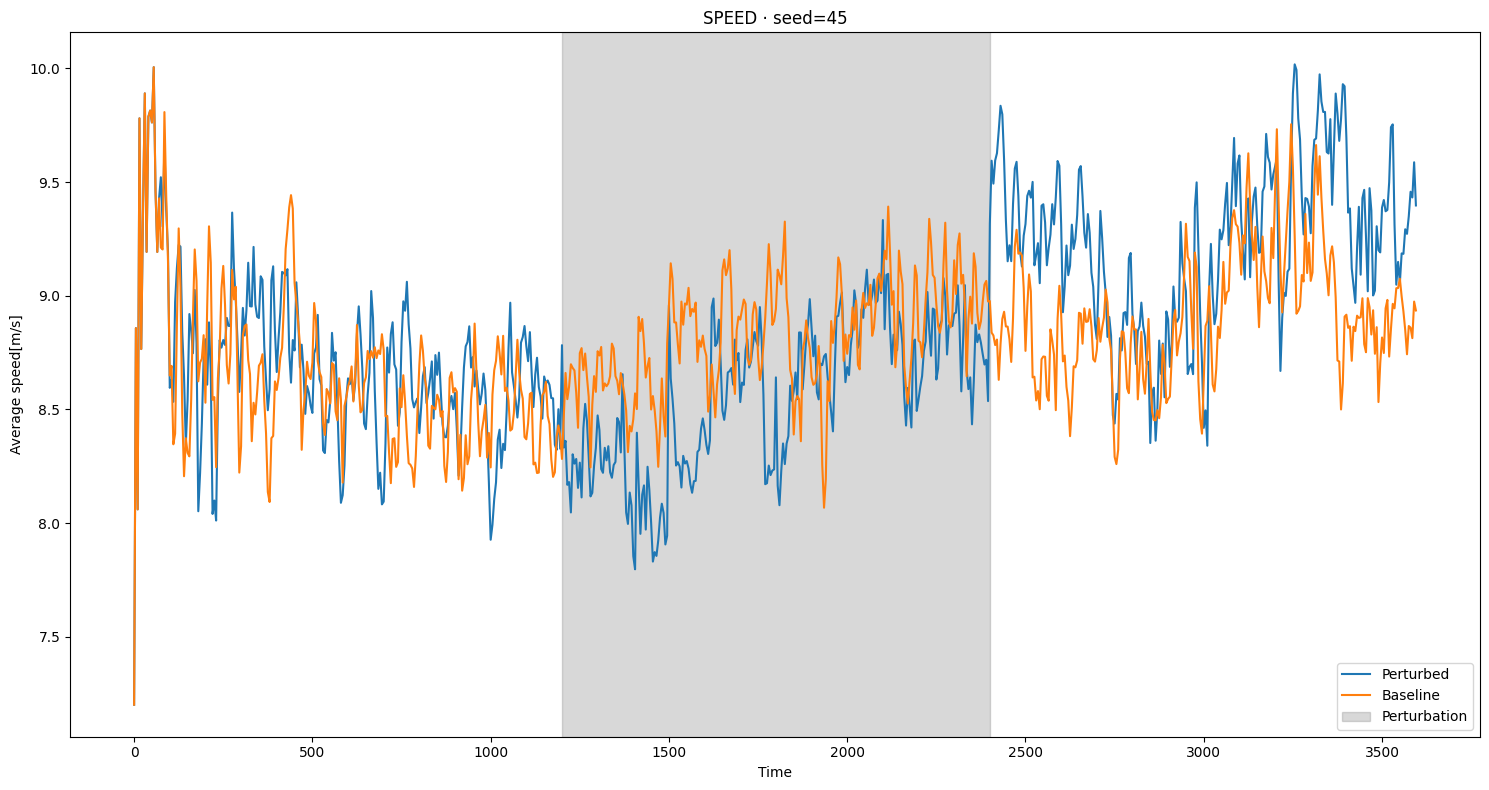

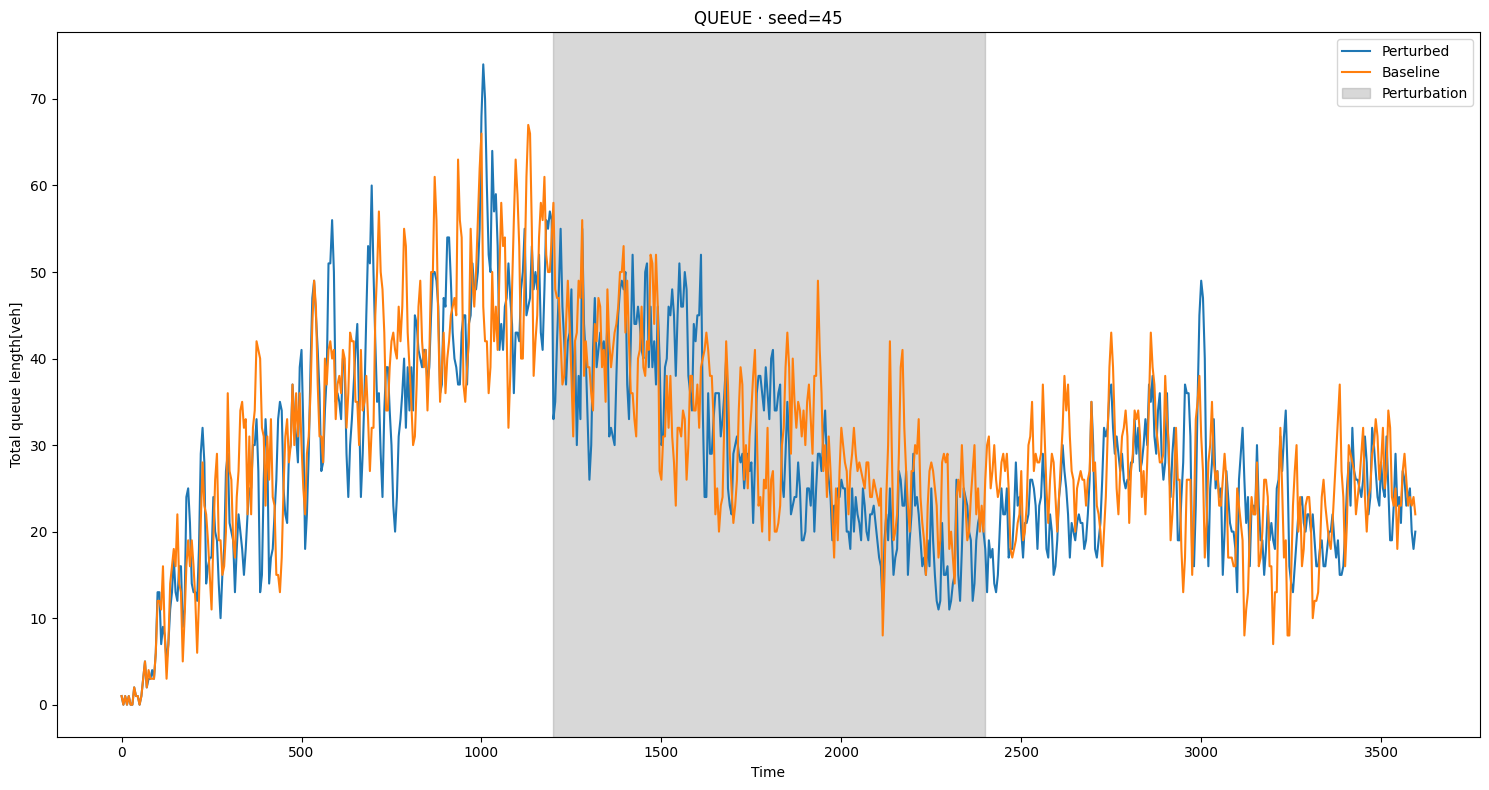

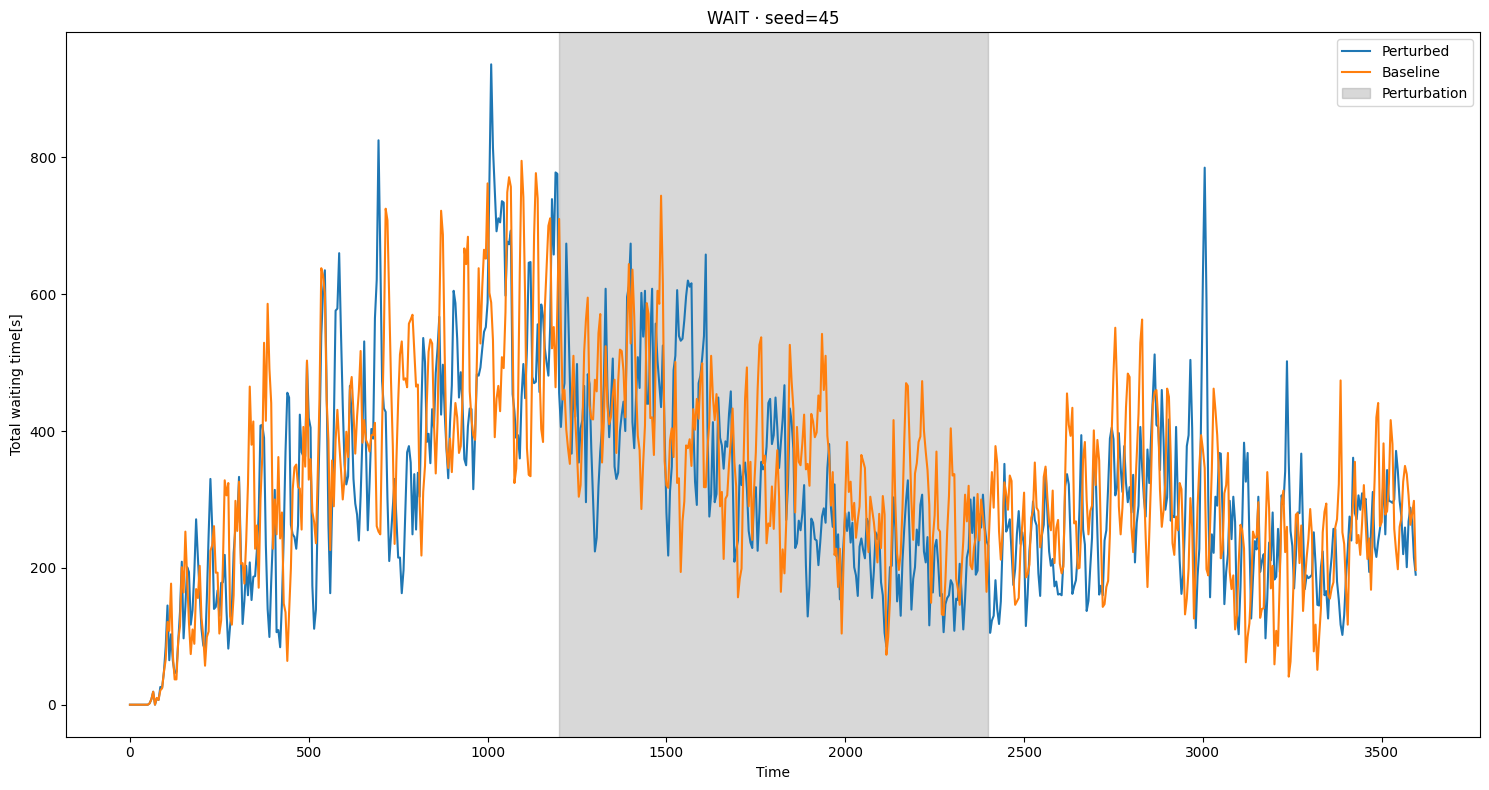

In [ ]:
ylabels = {"speed": "Average speed[m/s]", "queue": "Total queue length[veh]", "wait": "Total waiting time[s]"}
for name in SELECTED:
    plot_raw_overlay_simple(
        all_series_pert[SEED][name],
        all_series_base[SEED][name],
        wins,
        ylabel=ylabels.get(name, name),
        title=f"{name.upper()} · seed={SEED}"
    )